In [24]:
# OPTIONAL SETUP (run once if dependencies are not installed)
# import sys
# import subprocess
# subprocess.run(
#     [sys.executable, "-m", "pip", "install", "-r", "../requirements.txt"],
#     check=True
# )

In [2]:
from pathlib import Path
from zenodo_get import download
import utils
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import contextlib
from numpy.random import default_rng
import dask.array as da
from scipy.ndimage import gaussian_filter

# Introduction

This notebook tests the Plane Wave Fit package using synthetic SSHA data. The dataset spans three months, is sampled every 2 hours, and is defined on a 10 km Cartesian grid over a domain of −1000 to 1000 km in $x$ and −900 to 900 km in $y$.







## Initialization

- **Btwoild a synthetiAc SSH dastaset**

The synthetic SSHA field is defined on a Cartesian $(x,y)$ grid and sampled every 2 hours in time. The ideal signal is composed of three plane waves:
- Wave 1: M$_2$ frequency, wavelength 100 km, amplitude 10 mm, propagation direction 30°, phase 0°.
- Wave 2: S$_2$ frequency, wavelength 120 km, amplitude 5 mm, propagation direction 200°, phase 60°.
- Wave 3: K$_1$ frequency, wavelength 300 km, amplitude 1 mm,  propagation direction 340°, phase 100°.

Two synthetic SSHA examples are constructed:
- Example 1: the signal plus white noise with a standard deviation of 1 cm.
- Example 2: the signal plus the same white noise and an additional spatially and temporally correlated eddy field with 2 cm RMS amplitude, 120 km spatial decorrelation scale, and 30-day temporal decorrelation scale.


- **Prescribe wave parameters**

The SSHA field is modeled as a superposition of plane-wave components:

$$
\mathrm{SSHA}(x, y, t)
=
\sum_{m=1}^{N}
A_m
\cos\!\left(
k\,x\cos\theta_m
+
k\,y\sin\theta_m
-
\omega t
-
\phi_m
\right).
$$

Here, $A_m$, $\theta_m$, and $\phi_m$ are the amplitude, propagation direction, and phase of the $m$-th component; $k$ (rad km$^{-1}$) is the horizontal wavenumber magnitude; and $\omega$ (rad day$^{-1}$) is the M$_2$ angular frequency. The variables $x$ and $y$ denote eastward and northward Cartesian coordinates, and $t$ is time.

The horizontal wavenumber $k$ may be prescribed directly by the user. Otherwise, $k$ is obtained from a pre-calculated NetCDF file derived from climatological ocean stratification from the World Ocean Atlas 2023 (WOA23), archived at https://doi.org/10.5281/zenodo.18292089.




#### Build the ideal plane-wave signal



In [3]:
# -----------------------------
# Grid (km)
# Regular Cartesian grid used for all synthetic fields
# -----------------------------
dx_km = 10.0
x = np.arange(-1000, 1000 + dx_km, dx_km, dtype=np.float32)
y = np.arange(-900,   900 + dx_km, dx_km, dtype=np.float32)
X2, Y2 = np.meshgrid(x, y, indexing="xy")

# -----------------------------
# Time axis (2-hourly sampling)
# -----------------------------
t0 = np.datetime64("2023-04-01T00:00")
t1 = np.datetime64("2023-07-01T00:00")   # end-exclusive
dt_hours = 2
dt_days = dt_hours / 24.0

time = np.arange(t0, t1, np.timedelta64(dt_hours, "h"))  
t_days = ((time - t0) / np.timedelta64(1, "D")).astype(np.float32)

chunk_hours = 24  # 1 day chunks; adjust as needed
t_da = da.from_array(t_days, chunks=(chunk_hours,))  # (time,)

# -----------------------------
# Plane-wave parameters (3 components)
# Each wave is defined by amplitude, direction, phase,
# wavelength, and tidal frequency
# -----------------------------
A = np.array([1e-3*10.0, 1e-3*5.0, 1e-3*1.0], dtype=np.float32)  # amplitudes (m)
theta_deg = np.array([30.0, 200.0, 340.0], dtype=np.float32)     # propagation direction (deg)
phi_deg   = np.array([0.0, 60.0, 100.0], dtype=np.float32)       # phase (deg)

theta = np.deg2rad(theta_deg).astype(np.float32)
phi   = np.deg2rad(phi_deg).astype(np.float32)

lambda_km = np.array([100.0, 120.0, 300.0], dtype=np.float32) # wavelengths (km)
k = 2.0 * np.pi / lambda_km   # rad/km

# Frequencies (rad/day): M2, S2, K1
T_M2_day = 12.4206012 / 24.0
T_S2_day = 12.0       / 24.0
T_K1_day = 23.934472  / 24.0
omega = 2.0 * np.pi / np.array([T_M2_day, T_S2_day, T_K1_day], dtype=np.float32)  # rad/day


# -----------------------------
# Construct clean SSHA signal (lazy evaluation)
# signal(t, y, x) = Σ A_m cos(k_m (x cosθ_m + y sinθ_m) − ω_m t − φ_m)
# -----------------------------
spatial_phase = np.stack(
    [k[m] * (X2 * np.cos(theta[m]) + Y2 * np.sin(theta[m])) for m in range(3)],
    axis=0
).astype(np.float32)  # (m, y, x)

# Convert spatial_phase to dask, chunked in y/x for downstream slicing efficiency
spatial_da = da.from_array(spatial_phase, chunks=(3, 256, 256))  # (m, y, x)

# -----------------------------
# Build SSHA lazily with broadcasting
# SSHA(x,y,t) = sum_m A_m cos( spatial - omega_m t - phi_m ) + noise
# -----------------------------
A_da     = da.from_array(A, chunks=(3,))
omega_da = da.from_array(omega, chunks=(3,))
phi_da   = da.from_array(phi, chunks=(3,))

# phase_m: (m, time, y, x)
phase_m = (
    spatial_da[:, None, :, :]
    - omega_da[:, None, None, None] * t_da[None, :, None, None]
    - phi_da[:, None, None, None]
)

# sum over m -> (time, y, x)
signal = da.sum(A_da[:, None, None, None] * da.cos(phase_m), axis=0).astype(np.float32)


#### Build noise fields


In [4]:
# -----------------------------
# Noise component 1: white noise
# Spatially and temporally uncorrelated Gaussian noise
# -----------------------------
noise_std = 0.01 # 1cm
seed = 0
rs = da.random.RandomState(seed)

white = rs.normal(
    0.0, noise_std,
    size=signal.shape,
    chunks=signal.chunks
).astype(np.float32)

# -----------------------------
# Noise component 2: moderate mesoscale eddy field
# Spatially smooth and temporally correlated background variability
# -----------------------------
eddy_rms_m = 0.02   # 2 cm RMS
L_km = 120.0        # spatial decorrelation scale (km)
tau_days = 30.0     # temporal decorrelation scale (days)

# Build M smooth spatial patterns with ~L_km scale
M = 50                  # number of spatial modes (tradeoff: realism vs speed)
rng = np.random.default_rng(seed + 123)

# Convert correlation scale to Gaussian filter width (grid points)
# For a Gaussian filter, sigma is a reasonable proxy for a decorrelation length scale.
sigma_km = L_km / np.sqrt(2.0)
sigma_px = sigma_km / dx_km

patterns = np.empty((M, y.size, x.size), dtype=np.float32)
for j in range(M):
    w = rng.standard_normal(size=(y.size, x.size)).astype(np.float32)
    p = gaussian_filter(w, sigma=sigma_px, mode="nearest").astype(np.float32)
    p -= p.mean()
    p /= (p.std() + 1e-12)  # normalize each pattern to unit std
    patterns[j] = p

# Evolve coefficients with an OU/AR(1) process with decorrelation tau_days
alpha = float(np.exp(-dt_days / tau_days))                 # AR(1) coefficient
sigma_eps = float(np.sqrt(1.0 - alpha**2))                 # keeps Var(c)=1 in steady state

nt = time.size
coeff = np.empty((nt, M), dtype=np.float32)
coeff[0] = rng.standard_normal(size=(M,)).astype(np.float32)
for it in range(1, nt):
    eps = rng.standard_normal(size=(M,)).astype(np.float32)
    coeff[it] = alpha * coeff[it - 1] + sigma_eps * eps

# Scale so that spatial-average RMS is ~eddy_rms_m
# With unit-std patterns and Var(coeff)=1, spatial-average variance ~ M.
scale = eddy_rms_m / np.sqrt(M)
coeff *= scale

# Make a lazy dask eddy field and add to the signal
coeff_da = da.from_array(coeff, chunks=(chunk_hours, M))           # (time, M)
patterns_da = da.from_array(patterns, chunks=(M, 256, 256))        # (M, y, x)
eddy1 = da.tensordot(coeff_da, patterns_da, axes=(1, 0)).astype(np.float32)  # (time, y, x)


# -----------------------------
# Noise component 3: strong mesoscale eddy field
# Spatially smooth and temporally correlated background variability
# -----------------------------
eddy_rms_m = 0.2   # 20 cm RMS
L_km = 200.0        # spatial decorrelation scale (km)
tau_days = 60.0     # temporal decorrelation scale (days)

# Build M smooth spatial patterns with ~L_km scale
M = 50                  # number of spatial modes (tradeoff: realism vs speed)
rng = np.random.default_rng(seed + 123)

# Convert correlation scale to Gaussian filter width (grid points)
# For a Gaussian filter, sigma is a reasonable proxy for a decorrelation length scale.
sigma_km = L_km / np.sqrt(2.0)
sigma_px = sigma_km / dx_km

patterns = np.empty((M, y.size, x.size), dtype=np.float32)
for j in range(M):
    w = rng.standard_normal(size=(y.size, x.size)).astype(np.float32)
    p = gaussian_filter(w, sigma=sigma_px, mode="nearest").astype(np.float32)
    p -= p.mean()
    p /= (p.std() + 1e-12)  # normalize each pattern to unit std
    patterns[j] = p

# Evolve coefficients with an OU/AR(1) process with decorrelation tau_days
alpha = float(np.exp(-dt_days / tau_days))                 # AR(1) coefficient
sigma_eps = float(np.sqrt(1.0 - alpha**2))                 # keeps Var(c)=1 in steady state

nt = time.size
coeff = np.empty((nt, M), dtype=np.float32)
coeff[0] = rng.standard_normal(size=(M,)).astype(np.float32)
for it in range(1, nt):
    eps = rng.standard_normal(size=(M,)).astype(np.float32)
    coeff[it] = alpha * coeff[it - 1] + sigma_eps * eps

# Scale so that spatial-average RMS is ~eddy_rms_m
# With unit-std patterns and Var(coeff)=1, spatial-average variance ~ M.
scale = eddy_rms_m / np.sqrt(M)
coeff *= scale

# Make a lazy dask eddy field and add to the signal
coeff_da = da.from_array(coeff, chunks=(chunk_hours, M))           # (time, M)
patterns_da = da.from_array(patterns, chunks=(M, 256, 256))        # (M, y, x)
eddy2 = da.tensordot(coeff_da, patterns_da, axes=(1, 0)).astype(np.float32)  # (time, y, x)

#### build synthetic datasets

In [5]:
# -----------------------------
# Final synthetic fields
# Example 1: signal + white noise
# Example 2: signal + white noise + eddy noise
# -----------------------------
ssha1 = signal + white
ssha2 = signal + white + eddy1
ssha3 = signal + white + eddy2

# -----------------------------
# Wrap fields into xarray Datasets
# Each dataset contains:
#   - signal : clean plane-wave truth
#   - noise  : total noise added
#   - ssha   : observed field (signal + noise)
# -----------------------------
ds_ex1 = xr.Dataset(
    data_vars={
        "signal": (("time", "y", "x"), signal),
        "noise":  (("time", "y", "x"), white),
        "ssha":   (("time", "y", "x"), ssha1),
    },
    coords={"time": time, "x": x, "y": y},
    attrs={
        "description": "Example 1: SSHA = 3 plane waves (M2,S2,K1) + white noise",
        "x_units": "km",
        "y_units": "km",
        "time_step_hours": dt_hours,
        "omega_units": "rad/day",
        "k_units": "rad/km",
        "noise_model": "white",
        "noise_std_m": float(noise_std),
        "waves": "A=[10,5,1], theta_deg=[30,200,340], phi_deg=[0,60,100], lambda_km=[100,120,300]",
        "time_range": f"{str(t0)} to {str(t1)} (2-hourly, end-exclusive)",
    },
)

ds_ex2 = xr.Dataset(
    data_vars={
        "signal": (("time", "y", "x"), signal),
        "noise":  (("time", "y", "x"), white + eddy1),
        "ssha":   (("time", "y", "x"), ssha2),
    },
    coords={"time": time, "x": x, "y": y},
    attrs={
        "description": "Example 2: SSHA = 3 plane waves (M2,S2,K1) + white noise + correlated eddy field",
        "x_units": "km",
        "y_units": "km",
        "time_step_hours": dt_hours,
        "omega_units": "rad/day",
        "k_units": "rad/km",
        "noise_model": "white + eddy",
        "noise_std_m": float(noise_std),
        "eddy_rms_m": float(eddy_rms_m),
        "eddy_L_km": float(L_km),
        "eddy_tau_days": float(tau_days),
        "eddy_num_patterns": int(M),
        "waves": "A=[10,5,1], theta_deg=[30,200,340], phi_deg=[0,60,100], lambda_km=[100,120,300]",
        "time_range": f"{str(t0)} to {str(t1)} (2-hourly, end-exclusive)",
    },
)


ds_ex3 = xr.Dataset(
    data_vars={
        "signal": (("time", "y", "x"), signal),
        "noise":  (("time", "y", "x"), white + eddy2),
        "ssha":   (("time", "y", "x"), ssha3),
    },
    coords={"time": time, "x": x, "y": y},
    attrs={
        "description": "Example 2: SSHA = 3 plane waves (M2,S2,K1) + white noise + correlated eddy field",
        "x_units": "km",
        "y_units": "km",
        "time_step_hours": dt_hours,
        "omega_units": "rad/day",
        "k_units": "rad/km",
        "noise_model": "white + eddy",
        "noise_std_m": float(noise_std),
        "eddy_rms_m": float(eddy_rms_m),
        "eddy_L_km": float(L_km),
        "eddy_tau_days": float(tau_days),
        "eddy_num_patterns": int(M),
        "waves": "A=[10,5,1], theta_deg=[30,200,340], phi_deg=[0,60,100], lambda_km=[100,120,300]",
        "time_range": f"{str(t0)} to {str(t1)} (2-hourly, end-exclusive)",
    },
)


# Compute one snapshot RMS for each (computes only one time slice)
print("white snapshot std:", float(ds_ex1.ssha.isel(time=0).std().compute()))
print("white+eddy snapshot std:", float(ds_ex2.ssha.isel(time=0).std().compute()))
print("white snapshot std:", float(ds_ex3.ssha.isel(time=0).std().compute()))

C:\Users\Owner\AppData\Local\Temp\ipykernel_22524\3415039683.py:17: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_ex1 = xr.Dataset(
C:\Users\Owner\AppData\Local\Temp\ipykernel_22524\3415039683.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenc

white snapshot std: 0.012753965333104134
white+eddy snapshot std: 0.022356338798999786
white snapshot std: 0.16734541952610016


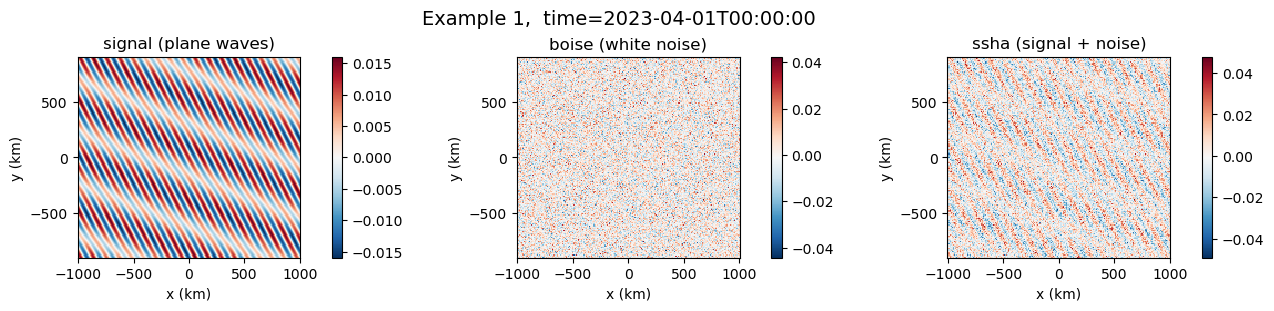

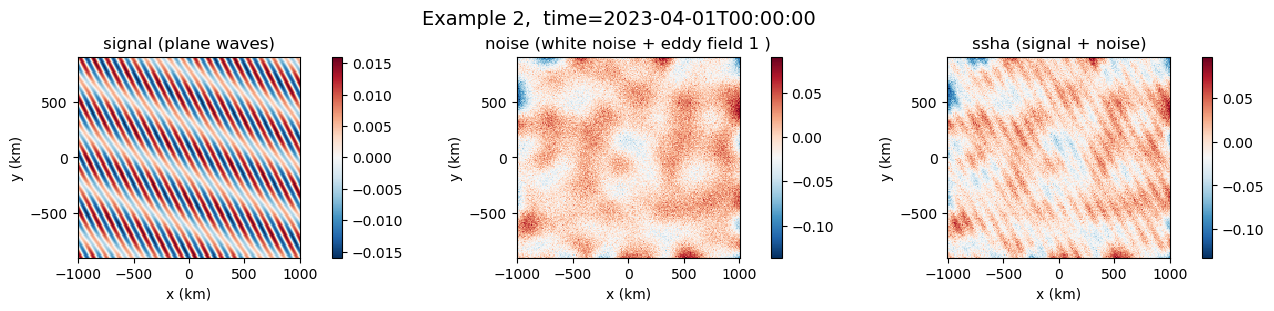

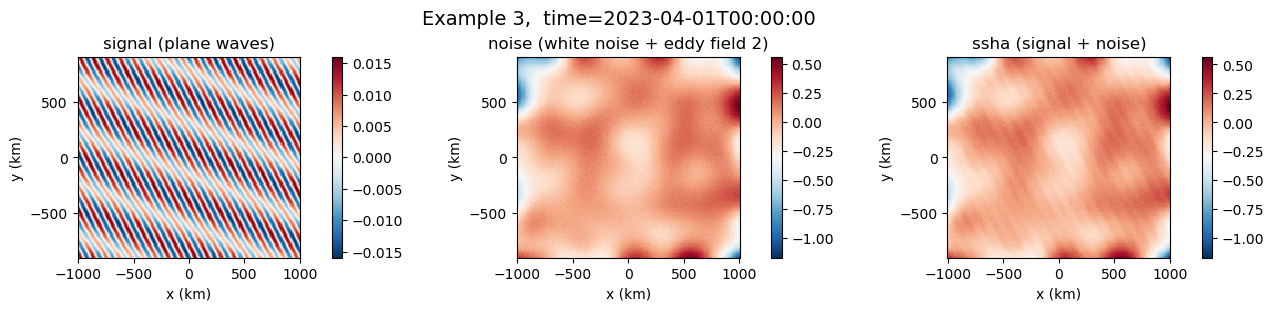

In [54]:
def plot_ds_fields(ds, title="", time_index=0, noise_title = 'noise'):
    """
    Plot 3 panels for a given dataset at a single time:
      (a) signal, (b) noise, (c) ssha = signal + noise
    """
    sig = ds["signal"].isel(time=time_index)
    noi = ds["noise"].isel(time=time_index)
    tot = ds["ssha"].isel(time=time_index)

    fig, axs = plt.subplots(1, 3, figsize=(13, 3), constrained_layout=True)

    im0 = axs[0].pcolormesh(ds["x"], ds["y"], sig, shading="auto",cmap="RdBu_r")
    axs[0].set_title("signal (plane waves)")
    axs[0].set_xlabel("x (km)"); axs[0].set_ylabel("y (km)")
    axs[0].set_aspect("equal", adjustable="box")
    fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].pcolormesh(ds["x"], ds["y"], noi, shading="auto",cmap="RdBu_r")
    # axs[1].set_title("noise")
    axs[1].set_title(noise_title)
    axs[1].set_xlabel("x (km)"); axs[1].set_ylabel("y (km)")
    axs[1].set_aspect("equal", adjustable="box")
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].pcolormesh(ds["x"], ds["y"], tot, shading="auto",cmap="RdBu_r")
    axs[2].set_title("ssha (signal + noise)")
    axs[2].set_xlabel("x (km)"); axs[2].set_ylabel("y (km)")
    axs[2].set_aspect("equal", adjustable="box")
    fig.colorbar(im2, ax=axs[2])

    tstamp = np.datetime_as_string(ds["time"].isel(time=time_index).values,unit="s")
    fig.suptitle(f"{title},  time={tstamp}", fontsize=14)
    plt.show()


# --- Two figures: Example 1 and Example 2 ---
plot_ds_fields(ds_ex1, title="Example 1", time_index=0, noise_title = 'boise (white noise)')
plot_ds_fields(ds_ex2, title="Example 2", time_index=0, noise_title = 'noise (white noise + eddy field 1 )')
plot_ds_fields(ds_ex3, title="Example 3", time_index=0, noise_title = 'noise (white noise + eddy field 2)')

#### Load prescribed wave parameters: wave frequency and wavenumber

Here I use M2 wave frequency, and the wavenumber at the example site. 

If you would like to access the precomputed internal-tide parameters used here (and explore additional fields such as phase speed, group speed, and vertical mode structure), see the companion notebook **`<lookup_mode1_M2_wave_parameters.ipynb>`**, which demonstrates how to load the precomputed lookup table and extract the mode-1 M$_2$ wavenumber and related fields at any longitude and latitude.

In [10]:
omega1, omega2, omega3 = omega[0], omega[1], omega[2]
k1, k2, k3 = k[0], k[1], k[2]

#### construct three-dimensional x, y, time, and ssha

In [11]:
ssha1 = ds_ex1['ssha'].values  # SSHA (m)
ssha2 = ds_ex2['ssha'].values  # SSHA (m)
ssha3 = ds_ex3['ssha'].values
T_3D = t_days[:, None, None] * np.ones((1, y.size, x.size), dtype=np.float32)
Y_3D = np.ones((t_days.size, 1, x.size), dtype=np.float32) * y[None, :, None]
X_3D = np.ones((t_days.size, y.size, 1), dtype=np.float32) * x[None, None, :]

#### Apply the Plane Wave Fit code

For each fitting window, the amplitude and phase of a plane wave are determined for each compass direction (angular increment 1$^{\circ}$) using least-squares fitting. When the fitted amplitudes are plotted as a function of direction in polar coordinates, an internal tidal wave appears to be a lobe. The largest lobe gives the amplitude and direction of the strongest internal tidal wave. The signal of this wave is then predicted and removed from the initial SSHA measurements. This procedure can be repeated to extract an arbitrary number of M$_2$ internal tidal waves. Here, the analysis is conducted to the first three waves.

**Inputs**
- `data_3D` (`ssha`): SSHA values on a 3-D window with shape `(time, x, y)` (NaNs allowed).
- `k` (rad km$^{-1}$): prescribed horizontal wavenumber magnitude.
- `omega` (rad day$^{-1}$): prescribed angular frequency.
- `X_3D`, `Y_3D` (km): local Cartesian coordinates for each SSHA sample in the window (same shape as `data_3D`).
- `T_3D` (day): observation time for each sample (same shape as `data_3D`).

**Outputs**
- `max_amplitude`: amplitude (m).
- `max_angle`: propagation direction (degrees).
- `phase`: phase (rad)
- `best_predicted_wave`: reconstructed mode-1 M2 SSH time series at the example site.
- `residual_variances`: remaining (unexplained) variance after fitting a plane wave for each propagation direction.
- `amplitudes`: fitted amplitude for compass direction.
- `phases`: fitted phase for each compass direction.
- `uncertainty_estimates`: dictionary containing regression uncertainty diagnostics.
  - `dof`: degrees of freedom used in the least-squares fit.
  - `t_critical`: critical value of the Student’s *t* distribution for a 95% confidence interval.
  - `beta`: fitted regression coefficients `[β_cos, β_sin]` for the cosine and sine components of the plane-wave model.
  - `standard_errors_beta`: standard errors of the regression coefficients, derived from the coefficient covariance matrix.
  - `standard_error_amplitude`: approximate standard error of the fitted wave amplitude, propagated from the coefficient uncertainties.
  - `standard_error_phase`: approximate standard error of the fitted wave phase, propagated from the coefficient uncertainties.
  - `cov_matrix_beta`: covariance matrix of the fitted regression coefficients.



#### synthethic ssha dataset1

In [12]:
results_ex1 = {}

results_ex1["wave1"] = utils.fit_wave(ssha1, k1, omega1, X_3D, Y_3D, T_3D)
max_amplitude1, max_angle1, phase1, best_predicted_wave1, residual_variances1, amplitudes1, phases1, uncertainty_estimates1 = results_ex1["wave1"]

results_ex1["wave2"] = utils.fit_wave(ssha1 - best_predicted_wave1, k2, omega2, X_3D, Y_3D, T_3D)
max_amplitude2, max_angle2, phase2, best_predicted_wave2, residual_variances2, amplitudes2, phases2, uncertainty_estimates2 = results_ex1["wave2"]

results_ex1["wave3"] = utils.fit_wave(ssha1 - best_predicted_wave1 - best_predicted_wave2, k3, omega3, X_3D, Y_3D, T_3D)
max_amplitude3, max_angle3, phase3, best_predicted_wave3, residual_variances3, amplitudes3, phases3, uncertainty_estimates3 = results_ex1["wave3"]


#### synthetic ssha dataset2

In [38]:
results_ex2 = {}

results_ex2["wave1"] = utils.fit_wave(ssha2, k1, omega1, X_3D, Y_3D, T_3D)
max_amplitude1, max_angle1, phase1, best_predicted_wave1, residual_variances1, amplitudes1, phases1, uncertainty_estimates1 = results_ex2["wave1"]

results_ex2["wave2"] = utils.fit_wave(ssha2 - best_predicted_wave1, k2, omega2, X_3D, Y_3D, T_3D)
max_amplitude2, max_angle2, phase2, best_predicted_wave2, residual_variances2, amplitudes2, phases2, uncertainty_estimates2 = results_ex2["wave2"]

results_ex2["wave3"] = utils.fit_wave(ssha2 - best_predicted_wave1 - best_predicted_wave2, k3, omega3, X_3D, Y_3D, T_3D)
max_amplitude3, max_angle3, phase3, best_predicted_wave3, residual_variances3, amplitudes3, phases3, uncertainty_estimates3 = results_ex2["wave3"]


#### synthetic ssha dataset3

In [12]:
results_ex3 = {}

results_ex3["wave1"] = utils.fit_wave(ssha3, k1, omega1, X_3D, Y_3D, T_3D)
max_amplitude1, max_angle1, phase1, best_predicted_wave1, residual_variances1, amplitudes1, phases1, uncertainty_estimates1 = results_ex3["wave1"]

results_ex3["wave2"] = utils.fit_wave(ssha3 - best_predicted_wave1, k2, omega2, X_3D, Y_3D, T_3D)
max_amplitude2, max_angle2, phase2, best_predicted_wave2, residual_variances2, amplitudes2, phases2, uncertainty_estimates2 = results_ex3["wave2"]

results_ex3["wave3"] = utils.fit_wave(ssha3 - best_predicted_wave1 - best_predicted_wave2, k3, omega3, X_3D, Y_3D, T_3D)
max_amplitude3, max_angle3, phase3, best_predicted_wave3, residual_variances3, amplitudes3, phases3, uncertainty_estimates3 = results_ex3["wave3"]


The polar plots show the fitted plane-wave amplitude as a function of propagation direction for three independent realizations. The arrow marks the propagation direction of the fitted plane wave (i.e., the direction of the horizontal wavevector that maximizes the fitted amplitude) and the corresponding peak amplitude.


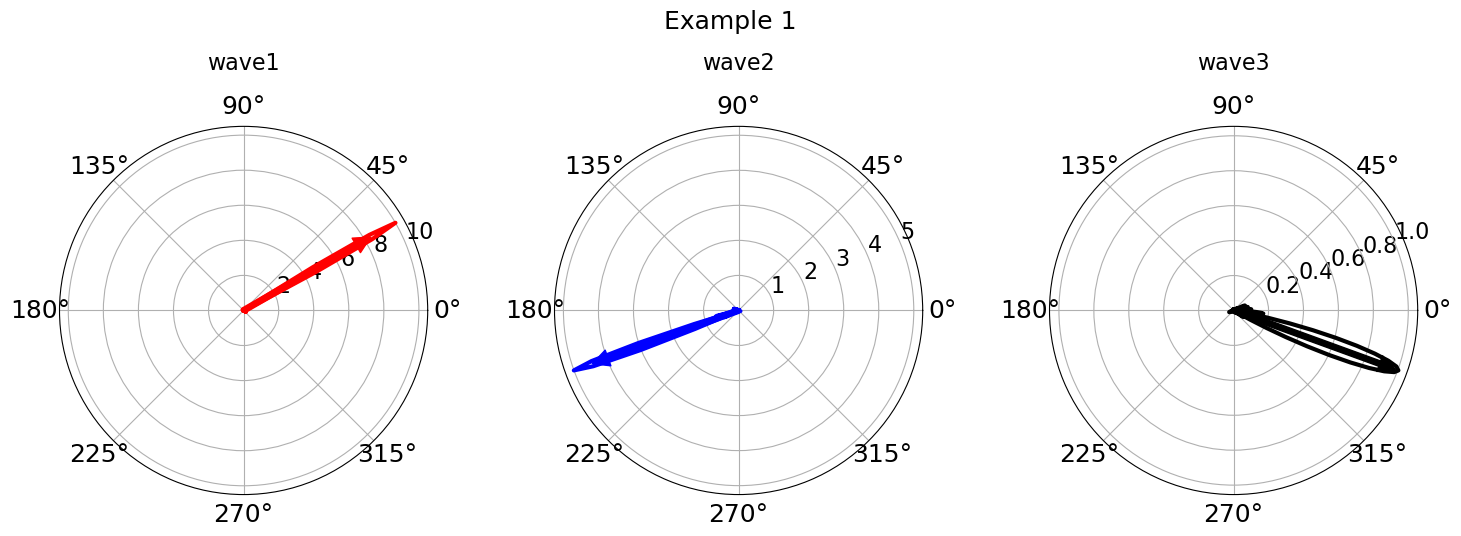

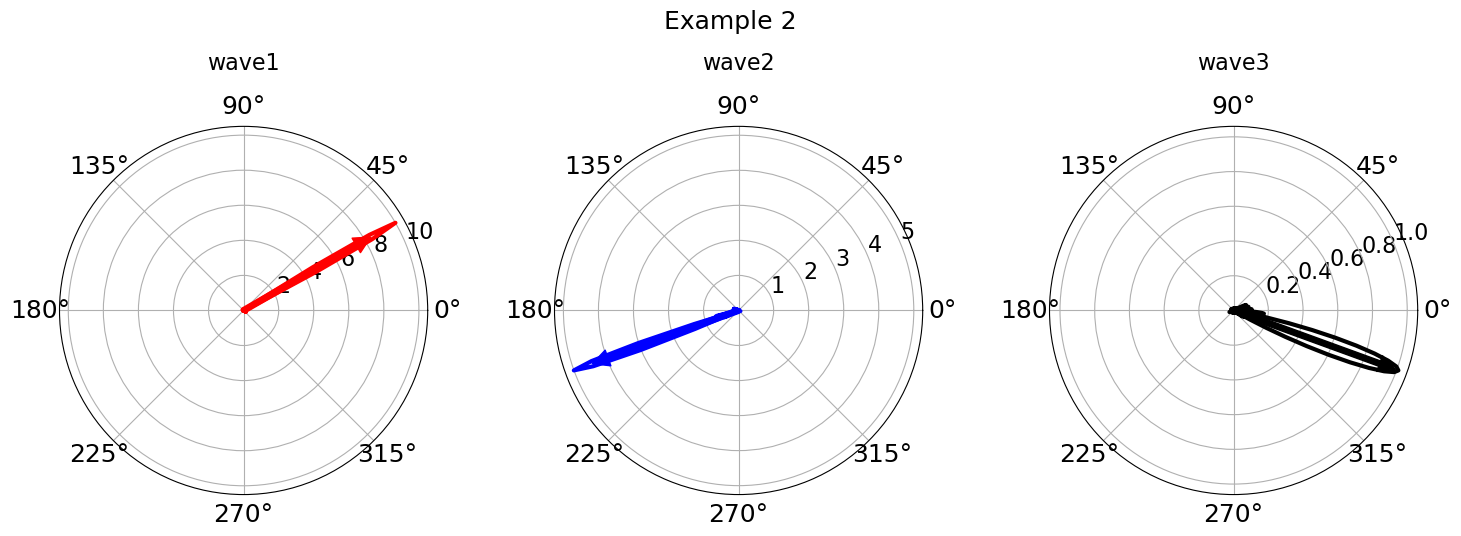

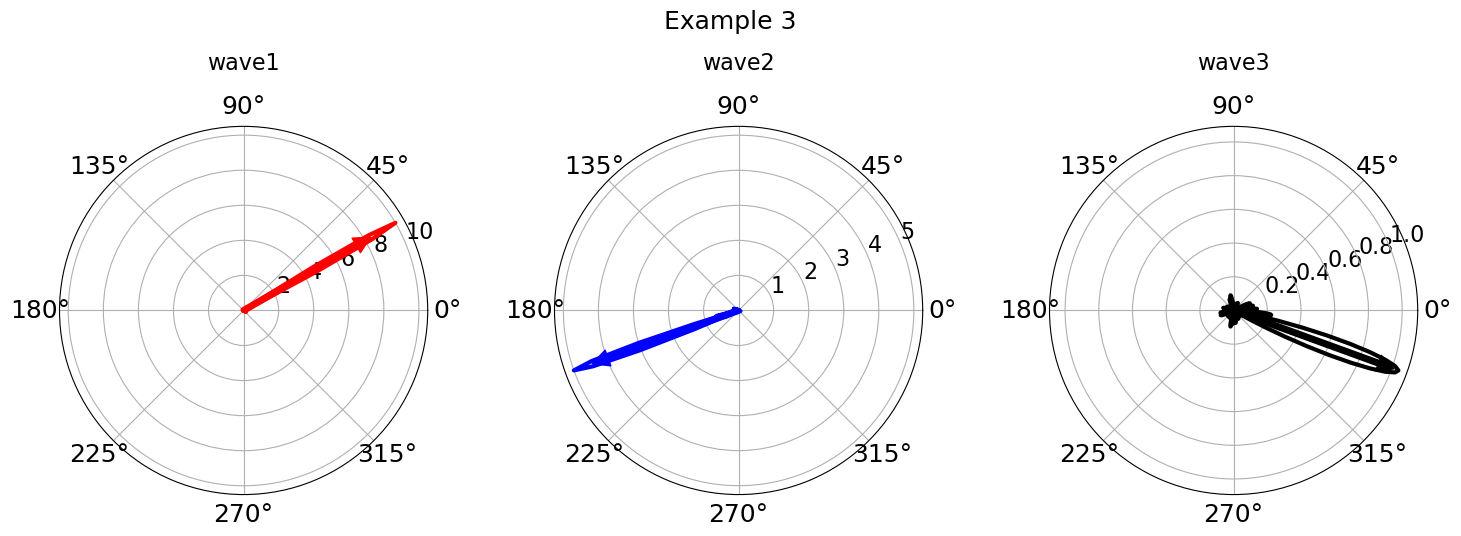

In [49]:
angles_degrees = np.arange(1, 361)
angles_radians = np.radians(angles_degrees)

colors = ['red', 'blue', 'black']

def plot_example(results_ex, title=""):
    # unpack from stored results: [max_amplitude, max_angle, phase, best_predicted_wave, residual_variances, amplitudes, phases, uncertainty_estimates]
    amplitudes_mm = [1e3 * results_ex[f"wave{i}"][5] for i in (1, 2, 3)]  # m -> mm
    max_angles_deg = [results_ex[f"wave{i}"][1] for i in (1, 2, 3)]      # degrees

    fig, axs = plt.subplots(1, 3, subplot_kw={'polar': True}, figsize=(15, 5))
    if title:
        fig.suptitle(title, fontsize=18, y=1.02)

    for i in range(3):
        ax = axs[i]
        amp = amplitudes_mm[i]
        color = colors[i]

        ax.plot(angles_radians, amp, color=color, linewidth=3)

        ax.set_theta_zero_location('E')
        ax.set_theta_direction(1)

        ax.tick_params(axis='x', labelsize=18)  # angular labels
        ax.tick_params(axis='y', labelsize=16)  # radial labels

        # Arrow direction
        arrow_angle_deg = max_angles_deg[i] % 360
        arrow_angle_rad = np.deg2rad(arrow_angle_deg)

        idx = int(round(arrow_angle_deg)) % 360
        arrow_length = amp[idx]

        ax.annotate(
            '',
            xy=(arrow_angle_rad, arrow_length),
            xytext=(0, 0),
            arrowprops=dict(facecolor=color, edgecolor=color, width=4, headwidth=12)
        )

        ax.set_title(f"wave{i+1}", fontsize=16, pad=18)

    plt.tight_layout()
    plt.show()


# ---- Make 2 figures (2 examples) ----
plot_example(results_ex1, title="Example 1: three plane waves + white noise")
plot_example(results_ex2, title="Example 2: three plane waves + white noise + moderate eddy field")
plot_example(results_ex3, title="Example 3: three plane waves + white noise + strong eddy field")

The table lists the amplitude, propagation direction, and phase for the first three extracted plane-wave components. Phases are wrapped to [0°, 360°]. 


In [55]:
def display_results_table(results_ex, title=""):
    # Extract per-wave quantities directly from the dict
    max_amplitudes = []
    max_angles = []
    phases_deg = []

    for i in [1, 2, 3]:
        max_amp, max_ang, phase, *_ = results_ex[f"wave{i}"]

        max_amplitudes.append(1e3 * max_amp)  # m -> mm
        max_angles.append(max_ang)
        phases_deg.append(((np.degrees(phase) + 180) % 360) - 180)

    tbl = {
        "Parameter": ["Amplitude (mm)", "Propagation direction (deg)", "Phase (deg)"],
        "Wave 1": [max_amplitudes[0], max_angles[0], phases_deg[0]],
        "Wave 2": [max_amplitudes[1], max_angles[1], phases_deg[1]],
        "Wave 3": [max_amplitudes[2], max_angles[2], phases_deg[2]],
    }

    df = pd.DataFrame(tbl).set_index("Parameter")

    if title:
        print(title)
    display(df.round(2))


display_results_table(results_ex1, title="Example 1: three plane waves + white noise")
display_results_table(results_ex2, title="Example 2: three plane waves + white noise + moderate eddy field")
display_results_table(results_ex3, title="Example 3: three plane waves + white noise + strong eddy field")

Example 1: three plane waves + white noise


,Wave 1,Wave 2,Wave 3
Parameter,,,
Amplitude (mm),10.0,5.00,1.00
Propagation direction (deg),30.0,200.00,340.00
Phase (deg),-0.0,60.04,99.94


Example 2: three plane waves + white noise + moderate eddy field


,Wave 1,Wave 2,Wave 3
Parameter,,,
Amplitude (mm),10.0,5.00,1.01
Propagation direction (deg),30.0,200.00,340.00
Phase (deg),-0.0,60.04,100.56


Example 3: three plane waves + white noise + strong eddy field


,Wave 1,Wave 2,Wave 3
Parameter,,,
Amplitude (mm),10.0,5.0,1.04
Propagation direction (deg),30.0,200.0,340.00
Phase (deg),0.0,60.0,102.37


print uncertainty estimates

In [56]:
pp = pprint.PrettyPrinter(indent=2, width=80)

all_results = {
    "Example 1 (white noise)": results_ex1,
    "Example 2 (white + moderate eddy)": results_ex2,
    "Example 3 (white + strong eddy)": results_ex3,
}

for ex_name, results in all_results.items():
    print("=" * 80)
    print(ex_name)
    print("=" * 80)

    for wave_key in ["wave1", "wave2", "wave3"]:
        uncertainty_estimates = results[wave_key][7]  # 8th output
        print(f"\nUncertainty estimate of {wave_key}:")
        pp.pprint(uncertainty_estimates)

    print("\n")


Example 1 (white noise)

Uncertainty estimate of wave1:
{ 'beta': array([ 1.0001354e-02, -4.4305710e-07], dtype=float32),
  'cov_matrix_beta': array([[5.6899802e-12, 1.3568387e-19],
       [1.3568387e-19, 5.6899914e-12]], dtype=float32),
  'dof': 39728050,
  'standard_error_amplitude': 2.3853679740698647e-06,
  'standard_error_phase': 0.00023850475420531572,
  'standard_errors_beta': array([2.3853679e-06, 2.3853704e-06], dtype=float32),
  't_critical': 1.9599640442528083}

Uncertainty estimate of wave2:
{ 'beta': array([0.00249914, 0.00433557], dtype=float32),
  'cov_matrix_beta': array([[5.0596151e-12, 2.6344668e-22],
       [2.6344668e-22, 5.0596229e-12]], dtype=float32),
  'dof': 39728050,
  'standard_error_amplitude': 2.24936009626577e-06,
  'standard_error_phase': 0.00044948656772716256,
  'standard_errors_beta': array([2.2493589e-06, 2.2493605e-06], dtype=float32),
  't_critical': 1.9599640442528083}

Uncertainty estimate of wave3:
{ 'beta': array([-0.00017329,  0.00098872], dtyp